In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D, GaussianNoise
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.metrics import peak_signal_noise_ratio
np.random.seed(21)

2024-12-15 13:53:54.546691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 13:53:54.558010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734270834.571586   18650 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734270834.575457   18650 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 13:53:54.588498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Prepare data

the shape of the train images (50000, 32, 32, 3)
the shape of the test images (10000, 32, 32, 3)


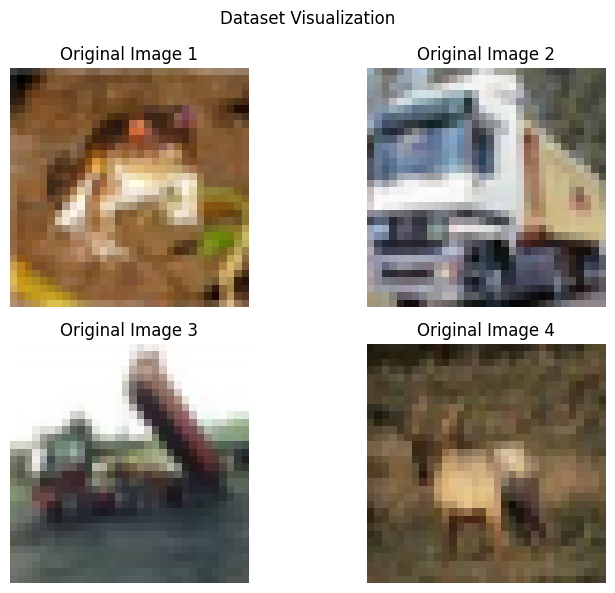

In [ ]:
# Load MNIST dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize and reshape to grayscale
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f'the shape of the train images', x_train.shape)
print(f'the shape of the test images', x_test.shape)

# Visualize first 4 images in the dataset
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(x_train[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
plt.suptitle('Dataset Visualization')
plt.tight_layout()
plt.show()

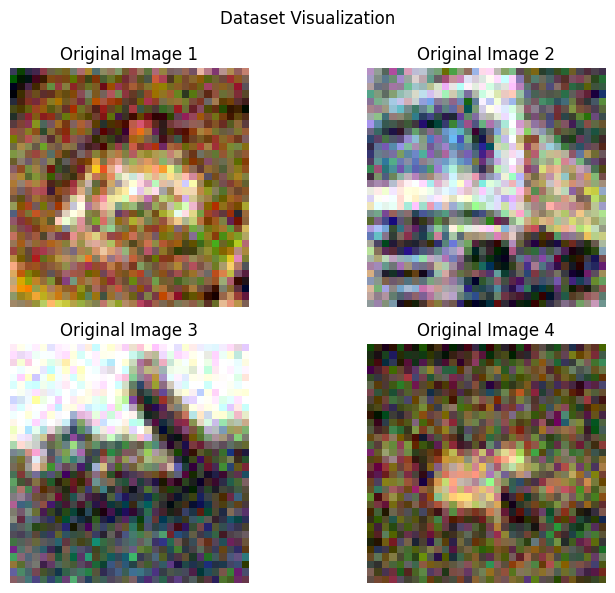

In [ ]:
def add_gaussian_noise(images, mu=0, sigma=0.1):
    noise = np.random.normal(loc=mu, scale=sigma, size=images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0., 1.)

x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)


# Visualize first 4 images in noisy dataset
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(x_train_noisy[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
plt.suptitle('Dataset Visualization')
plt.tight_layout()
plt.show()

# Fully Connected Autoencoder on Noisy Images

In [ ]:
input_img = Input(shape=x_train_noisy.shape[1:])
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(encoded)
x = Dense(np.prod(x_train_noisy.shape[1:]), activation='sigmoid')(x)
decoded = Reshape(x_train_noisy.shape[1:])(x)

fc_encoder_noisy = Model(input_img, encoded)
fc_decoder_noisy = Model(encoded, decoded)
fc_autoencoder_noisy = Model(input_img, decoded)

# Train on noisy images
fc_autoencoder_noisy.compile(optimizer='adam', loss='mse')
fc_autoencoder_noisy.fit(x_train_noisy, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test))

2024-12-15 13:54:23.010134: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0477 - val_loss: 0.0280
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0268 - val_loss: 0.0241
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0213 - val_loss: 0.0187
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0184 - val_loss: 0.0174
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0173 - val_loss: 0.0168
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 12/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 

# Fully Connected Autoencoder on Clear Images with Noise Added on compressed code (bottleneck).

In [ ]:
input_img = Input(shape=x_train.shape[1:])
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)
noisy_encoded = GaussianNoise(0.1)(encoded)
x = Dense(128, activation='relu')(noisy_encoded)
x = Dense(np.prod(x_train.shape[1:]), activation='sigmoid')(x)
decoded = Reshape(x_train.shape[1:])(x)

fc_encoder_clear = Model(input_img, encoded)
fc_decoder_clear = Model(noisy_encoded, decoded)
fc_autoencoder_clear = Model(input_img, decoded)

# Train on clear images
fc_autoencoder_clear.compile(optimizer='adam', loss='mse')
fc_autoencoder_clear.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0482 - val_loss: 0.0289
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0272 - val_loss: 0.0216
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0217 - val_loss: 0.0184
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0184 - val_loss: 0.0173
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0173 - val_loss: 0.0164
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 12/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 

# CNN Autoencoder on Noisy Images

In [ ]:
input_img = Input(shape=x_train_noisy.shape[1:])
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(x_train_noisy.shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

cnn_encoder_noisy = Model(input_img, encoded)
cnn_decoder_noisy = Model(encoded, decoded)
cnn_autoencoder_noisy = Model(input_img, decoded)

# Train on noisy images
cnn_autoencoder_noisy.compile(optimizer='adam', loss='mse')
cnn_autoencoder_noisy.fit(x_train_noisy, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/50
  1/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 951ms/step - loss: 0.0666

2024-12-15 13:59:02.556467: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 0.0274 - val_loss: 0.0087
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 12/50
196/196 ━━━━━━━━━━━━━━━━━━━━

# CNN Autoencoder on Clear Images with Noise Added on the compressed code (bottleneck).

In [ ]:
input_img = Input(shape=x_train.shape[1:])
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

noisy_encoded = GaussianNoise(0.1)(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(noisy_encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(x_train.shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

cnn_encoder_clear = Model(input_img, encoded)
cnn_decoder_clear = Model(noisy_encoded, decoded)
cnn_autoencoder_clear = Model(input_img, decoded)

# Train on clear images
cnn_autoencoder_clear.compile(optimizer='adam', loss='mse')
cnn_autoencoder_clear.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - loss: 0.0303 - val_loss: 0.0088
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.0092 - val_loss: 0.0068
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 12/50
196/196 ━━━━━━━━━━

# Test on the entire test set using encoder and decoder

In [ ]:
# Get compressed code and denoised predicted images of Fully Connected Autoencoder
compressed_code_fc_noisy = fc_encoder_noisy.predict(x_test_noisy)
denoised_images_fc_noisy = fc_decoder_noisy.predict(compressed_code_fc_noisy)

compressed_code_fc_clear = fc_encoder_clear.predict(x_test)
denoised_images_fc_clear = fc_decoder_clear.predict(compressed_code_fc_clear)

# Get compressed code and denoised predicted images of CNN Autoencoder
compressed_code_cnn_noisy = cnn_encoder_noisy.predict(x_test_noisy)
denoised_images_cnn_noisy = cnn_decoder_noisy.predict(compressed_code_cnn_noisy)

compressed_code_cnn_clear = cnn_encoder_clear.predict(x_test)
denoised_images_cnn_clear = cnn_decoder_clear.predict(compressed_code_cnn_clear)

# PCA as image denoiser and image compression technique.
x_test_noisy_flat = x_test_noisy.reshape(-1, np.prod(x_test_noisy.shape[1:]))
pca = PCA(n_components=64)
compressed_code_pca = pca.fit_transform(x_test_noisy_flat)
denoised_images_pca = pca.inverse_transform(compressed_code_pca).reshape(-1, *x_test_noisy.shape[1:])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# subjective Comparison

In [ ]:
def plot_images(original, noisy, compressed_code, denoised, title):
    plt.figure(figsize=(15, 4))
    plt.suptitle(title)
    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.title("Noisy")
    plt.imshow(noisy)
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title("Compressed Code")
    if len(compressed_code.shape) == 3:  # CNN compressed code
        plt.imshow(compressed_code[:, :, 0], cmap='gray')  # Show the first feature map
    else:  # Fully connected compressed code and PCA models
        plt.imshow(compressed_code.reshape(8, 8), cmap='gray')  # Reshape for visualization
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title("Denoised")
    plt.imshow(denoised)
    plt.axis('off')
    plt.show()

In [ ]:
# Access the first image from the original images and predicted results
sample_image = x_test[0]
noisy_image = x_test_noisy[0]

compressed_code_fc_noisy_first = compressed_code_fc_noisy[0]
denoised_image_fc_noisy_first = denoised_images_fc_noisy[0]

compressed_code_fc_clear_first = compressed_code_fc_clear[0]
denoised_image_fc_clear_first = denoised_images_fc_clear[0]

compressed_code_cnn_noisy_first = compressed_code_cnn_noisy[0]
denoised_image_cnn_noisy_first = denoised_images_cnn_noisy[0]

compressed_code_cnn_clear_first = compressed_code_cnn_clear[0]
denoised_image_cnn_clear_first = denoised_images_cnn_clear[0]

compressed_code_pca_first = compressed_code_pca[0]
denoised_image_pca_first = denoised_images_pca[0]

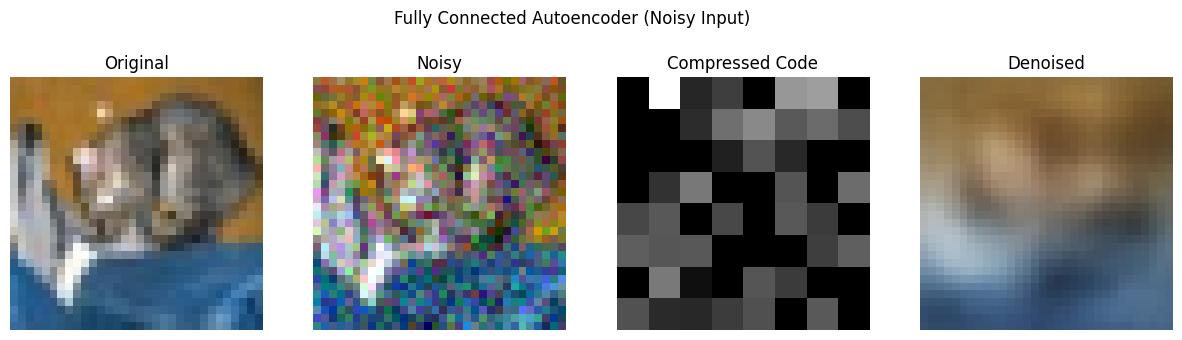

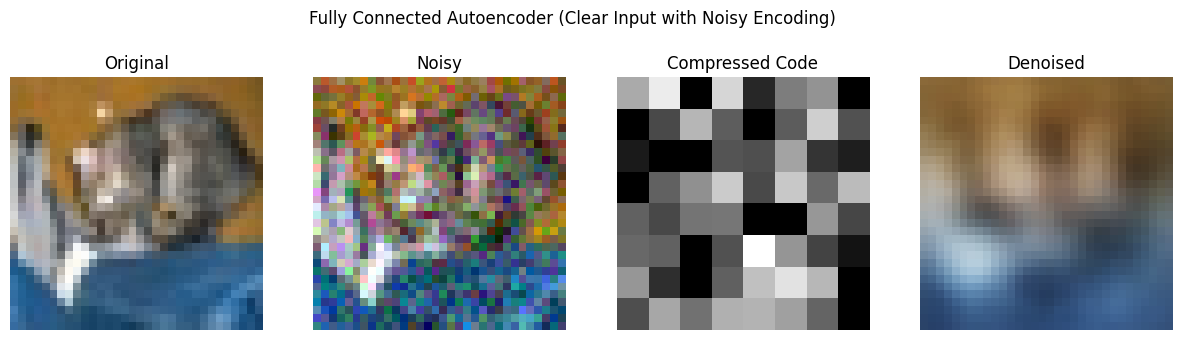

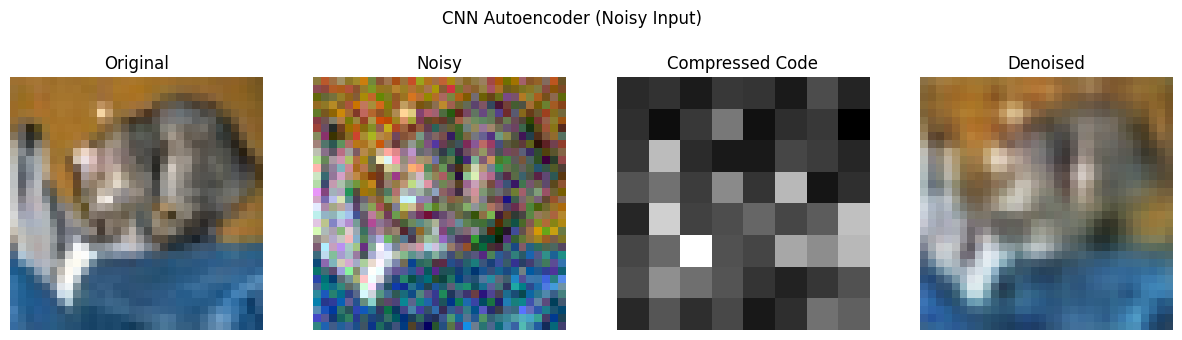

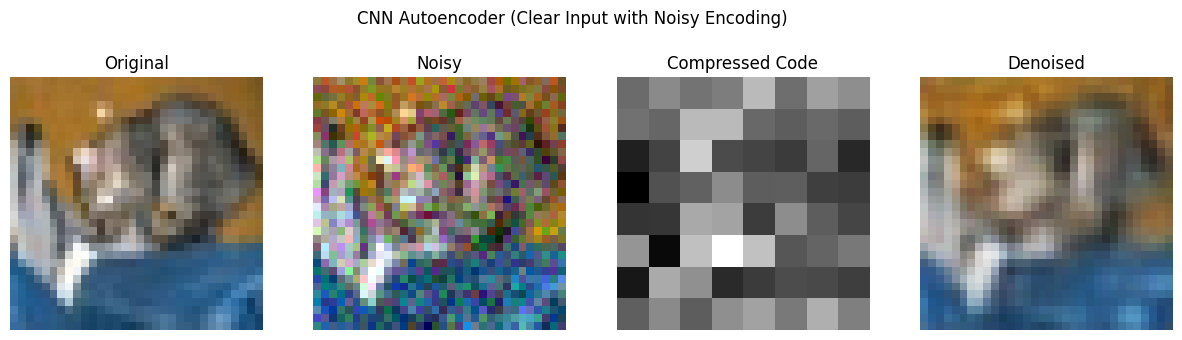

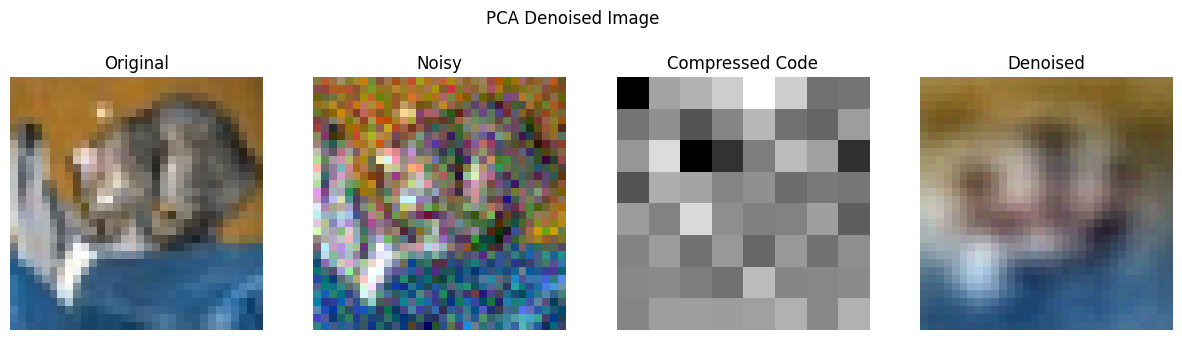

In [ ]:
plot_images(sample_image, noisy_image, compressed_code_fc_noisy_first, denoised_image_fc_noisy_first, "Fully Connected Autoencoder (Noisy Input)")
plot_images(sample_image, noisy_image, compressed_code_fc_clear_first, denoised_image_fc_clear_first, "Fully Connected Autoencoder (Clear Input with Noisy Encoding)")
plot_images(sample_image, noisy_image, compressed_code_cnn_noisy_first, denoised_image_cnn_noisy_first,"CNN Autoencoder (Noisy Input)")
plot_images(sample_image, noisy_image, compressed_code_cnn_clear_first, denoised_image_cnn_clear_first,"CNN Autoencoder (Clear Input with Noisy Encoding)")
plot_images(sample_image, noisy_image, compressed_code_pca_first, denoised_image_pca_first, "PCA Denoised Image")

# **Objective Comparison using Peak Signal-to-Noise Ratio (PSNR)**
  
PSNR measures the quality of a reconstructed or processed image by comparing it to a reference (original) image. It quantifies how similar the processed image is to the reference in terms of fidelity. Higher PSNR values indicate better quality.

---

### **PSNR Formulas**

1. **Mean Squared Error (MSE)**:
   $$
   MSE = \frac{1}{m \cdot n} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} \left( I_1(i,j) - I_2(i,j) \right)^2
   $$
   - \( I_1(i,j) \): Pixel value at \((i,j)\) in the reference image.  
   - \( I_2(i,j) \): Pixel value at \((i,j)\) in the processed image.  
   - \( m, n \): Dimensions of the image.

2. **PSNR**:
   $$
   PSNR = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{MSE} \right)
   $$
   - \( MAX_I \): The maximum possible pixel value of the image (e.g., 255 for 8-bit images).  
   - \( MSE \): Mean Squared Error between the two images.
---

#### **Interpretation**:
- **Higher PSNR**: Better image quality (processed image closer to the reference).  
- **Typical Ranges**:
  - **PSNR > 30 dB**: High quality (indistinguishable differences).  
  - **20–30 dB**: Medium quality (noticeable differences but acceptable).  
  - **PSNR < 20 dB**: Low quality (distortions are easily noticeable).

---
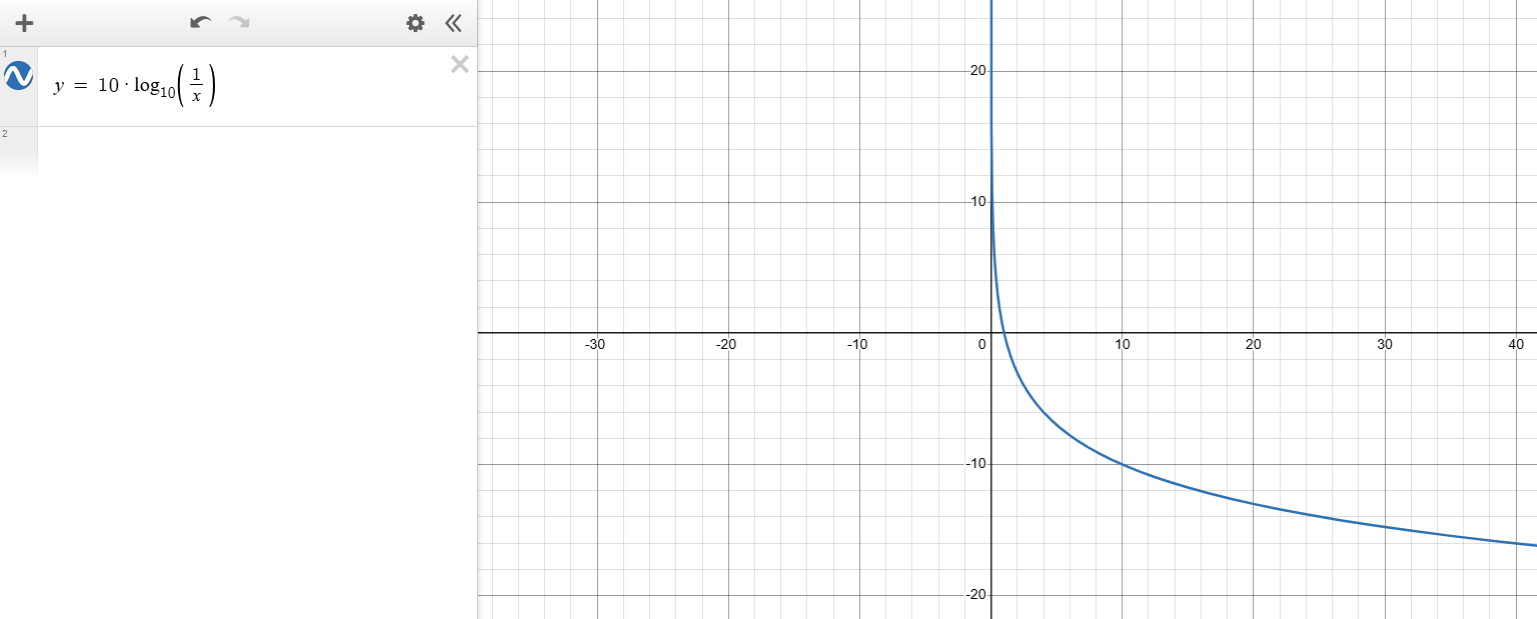

In [ ]:
psnr_fc_noisy = peak_signal_noise_ratio(sample_image, denoised_image_fc_noisy_first)
psnr_fc_clear = peak_signal_noise_ratio(sample_image, denoised_image_fc_clear_first)
psnr_cnn_noisy = peak_signal_noise_ratio(sample_image, denoised_image_cnn_noisy_first)
psnr_cnn_clear = peak_signal_noise_ratio(sample_image, denoised_image_cnn_clear_first)
psnr_pca = peak_signal_noise_ratio(sample_image, denoised_image_pca_first)

/tmp/ipykernel_18650/4215047290.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_pca = peak_signal_noise_ratio(sample_image, denoised_image_pca_first)


In [ ]:
print(f"PSNR FC Noisy: {psnr_fc_noisy}")
print(f"PSNR CNN Noisy: {psnr_cnn_noisy}")
print(f"PSNR FC Clear: {psnr_fc_clear}")
print(f"PSNR CNN Clear: {psnr_cnn_clear}")
print(f"PSNR PCA: {psnr_pca}")

PSNR FC Noisy: 18.237812569240692
PSNR CNN Noisy: 23.646918513514695
PSNR FC Clear: 18.88105484442605
PSNR CNN Clear: 24.276360458827565
PSNR PCA: 19.91140783799468
